# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [0]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import linear_model as lm
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LassoCV
import statsmodels.formula.api as formulas
%matplotlib inline

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [0]:
#your code here
train_data = pd.read_csv("Bikeshare_train.csv", sep = ",", header = 0)
test_data = pd.read_csv("Bikeshare_test.csv", sep = ",", header = 0)

train_data.rename(index = str, columns = {"count":"rentals"}, inplace = True)
test_data.rename(index = str, columns = {"count":"rentals"}, inplace = True)

In [21]:
train_data

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0
5,5,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,69.7083,0.342667,4451.0
6,6,4.0,11.0,0.0,4.0,1.0,1.0,7.0,11.0,33.3478,0.347835,5315.0
7,7,2.0,6.0,0.0,2.0,1.0,1.0,23.0,26.0,50.7083,0.269283,4891.0
8,8,3.0,9.0,0.0,6.0,0.0,1.0,23.0,26.0,50.1667,0.247521,8714.0
9,9,3.0,8.0,0.0,3.0,1.0,1.0,30.0,30.0,61.9583,0.169771,7347.0


In [22]:
test_data

,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,3830.0
1,1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,2114.0
2,2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,915.0
3,3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,4322.0
4,4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,6591.0
5,5,3.0,8.0,0.0,2.0,1.0,1.0,25.0,26.0,54.8333,0.125008,5204.0
6,6,4.0,11.0,0.0,4.0,1.0,1.0,3.0,8.0,55.5652,0.115522,5323.0
7,7,3.0,9.0,1.0,1.0,0.0,2.0,27.0,28.0,79.0417,0.212696,3351.0
8,8,1.0,12.0,0.0,4.0,1.0,2.0,12.0,16.0,75.7500,0.047275,7258.0
9,9,2.0,6.0,0.0,2.0,1.0,2.0,26.0,27.0,83.3333,0.214546,4972.0


In [23]:
print(train_data.dtypes)
pd.set_option('display.max_rows', 500)
test_data

Unnamed: 0       int64
season         float64
month          float64
holiday        float64
day_of_week    float64
workingday     float64
weather        float64
temp           float64
atemp          float64
humidity       float64
windspeed      float64
rentals        float64
dtype: object


,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,3830.0
1,1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,2114.0
2,2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,915.0
3,3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,4322.0
4,4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,6591.0
5,5,3.0,8.0,0.0,2.0,1.0,1.0,25.0,26.0,54.8333,0.125008,5204.0
6,6,4.0,11.0,0.0,4.0,1.0,1.0,3.0,8.0,55.5652,0.115522,5323.0
7,7,3.0,9.0,1.0,1.0,0.0,2.0,27.0,28.0,79.0417,0.212696,3351.0
8,8,1.0,12.0,0.0,4.0,1.0,2.0,12.0,16.0,75.7500,0.047275,7258.0
9,9,2.0,6.0,0.0,2.0,1.0,2.0,26.0,27.0,83.3333,0.214546,4972.0


(array([111.,  45.,  41.,  41.,  93.]),
 array([0. , 1.2, 2.4, 3.6, 4.8, 6. ]),
 <a list of 5 Patch objects>)

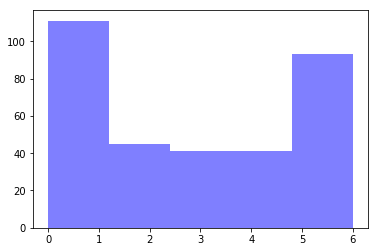

In [24]:
plt.hist(train_data['day_of_week'], 5, facecolor='blue', alpha=0.5)

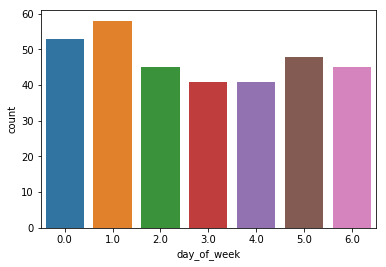

In [25]:
import seaborn as sns
%matplotlib inline

sns.countplot(x='day_of_week',data=train_data)

In [26]:
#for getting the average rentals on working day and non-working data

avg = [0, 0]

objects = ('0', '1')

y_pos = np.arange(len(objects))

#check for the non-working day and sum of bike rentals on working day same for working day

day = [train_data.loc[train_data['workingday'] == 0, 'rentals'].sum()]

day.append(train_data.loc[train_data['workingday'] == 1,'rentals'].sum())


number_of_entries = list(pd.value_counts(train['workingday'].values, sort=False))
number_of_entries = list(reversed(number_of_entries))

freq = train_data['workingday'].value_counts()

print(number_of_entries)

avg[0] = day[0]/freq[0]

avg[1] = day[1]/freq[1]

plt.bar(y_pos, avg, align='center', alpha=0.5) 
plt.xticks(y_pos, ['Non-working Day', 'Working Day']) 
plt.ylabel('Rental Counts') 
plt.title('Relative Rentals Weekend vs. Weekday') 
plt.show()

NameError: ignored

In [0]:
#for getting the average rentals on working day and non-working data

avg1 = [0, 0]

objects = ('0', '1')

y_pos = np.arange(len(objects))

#check for the non-working day and sum of bike rentals on working day same for working day

day1 = [train_data.loc[train_data['holiday'] == 0, 'rentals'].sum()]

day1.append(train_data.loc[train_data['holiday'] == 1,'rentals'].sum())


# number_of_entries = list(pd.value_counts(train['workingday'].values, sort=False))
# number_of_entries = list(reversed(number_of_entries))

freq1 = train_data['holiday'].value_counts()

# print(number_of_entries)

avg1[0] = day1[0]/freq1[0]

avg1[1] = day1[1]/freq1[1]

plt.bar(y_pos, avg1, align='center', alpha=0.5) 
plt.xticks(y_pos, ['Non-holiday', 'holiday']) 
plt.ylabel('Rental Counts') 
plt.title('Relative Rentals') 
plt.show()

In [0]:
#for getting the average rentals on working day and non-working data

avg2 = [0, 0, 0, 0]

objects = ('1', '2', '3', '4')

y_pos = np.arange(len(objects))

#check for the non-working day and sum of bike rentals on working day same for working day

day2 = [train_data.loc[train_data['season'] == 1, 'rentals'].sum()]

day2.append(train_data.loc[train_data['season'] == 2,'rentals'].sum())

day2.append(train_data.loc[train_data['season'] == 3,'rentals'].sum())

day2.append(train_data.loc[train_data['season'] == 4,'rentals'].sum())


# number_of_entries = list(pd.value_counts(train['workingday'].values, sort=False))
# number_of_entries = list(reversed(number_of_entries))

freq2 = train_data['season'].value_counts()

#print(number_of_entries)


# print(avg2)
# print(day2)
# print(freq2)
# print(freq2.iat[0])
# print(freq2.iat[1])
# print(freq2.iat[2])
# print(freq2.iat[3])
# freq2.iat[1]
avg2[0] = day2[0]/freq2.iat[1]

avg2[1] = day2[1]/freq2.iat[3]
avg2[2] = day2[2]/freq2.iat[0]
avg2[3] = day2[3]/freq2.iat[2]


plt.bar(y_pos, avg2, align='center', alpha=0.5) 
plt.xticks(y_pos, ['Spring', 'Summer', 'Fall', 'Winter']) 
plt.ylabel('Rental Counts') 
plt.title('Relative Rentals by season') 
plt.show()

your answers here

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [0]:
# your code here
Xtrain, ytrain = train_data.drop('rentals', axis =1), train_data['rentals'].values.reshape(-1,1)
Xtest, ytest = test_data.drop('rentals', axis =1), test_data['rentals'].values.reshape(-1, 1)


#building a multiple linear regression we have to fit some constant and fit the model
mult_reg = sm.OLS(ytrain, sm.add_constant(Xtrain)).fit()

ytest_pred = mult_reg.predict(sm.add_constant(Xtest))
ytrain_pred = mult_reg.predict(sm.add_constant(Xtrain))

In [0]:
print(mult_reg.summary())

your answers here

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

In [0]:
# your code here
corr = train_data.drop('rentals', axis = 1).corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr)

your answers here

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [0]:
# your code here
p_values = mult_reg.summary2().tables[1]['P>|t|']
p_values= p_values.sort_values()

print(p_values)

your answers here

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [0]:
# your code here
train_data.head(5)

your answers here

In [0]:
Xtrain, ytrain = train_data.drop(['rentals','holiday','workingday','temp','month'], axis =1), train_data['rentals'].values.reshape(-1,1)
Xtest, ytest = test_data.drop(['rentals','holiday','temp', 'workingday', 'month'], axis =1), test_data['rentals'].values.reshape(-1, 1)


#building a multiple linear regression we have to fit some constant and fit the model
mult_reg = sm.OLS(ytrain, sm.add_constant(Xtrain)).fit()

ytest_pred = mult_reg.predict(sm.add_constant(Xtest))
ytrain_pred = mult_reg.predict(sm.add_constant(Xtrain))

In [0]:
print(mult_reg.summary())

from the summary we can come to a conclusion that temp, season, day_of_week, weather and humidity are most significant features in the data set

so we can just consider these variables for our model prediction